In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from PIL import Image
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
VGG_MEAN = [103.939,116.779,123.68]
class VGGNet:
    
    def __init__(self, data_dict):
        self.data_dict = data_dict
    
    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name = 'conv')
    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name = 'fc')
    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name = 'bias')
    def conv_layer(self, x, name):
        with tf.name_scope(name):
            conv_w = self.get_conv_filter(name)
            conv_b = self.get_bias(name)
            h = tf.nn.conv2d(x, conv_w,[1,1,1,1], padding = 'SAME')
            h = tf.nn.bias_add(h, conv_b)
            h = tf.nn.relu(h)
            return h
    def pooling_layer(self, x, name):
        return tf.nn.max_pool(x, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME', name = name)
    
    def fc_layer(self, x, name, activation = tf.nn.relu):
        with tf.name_scope(name):
            fc_w = self.get_fc_weight(name)
            fc_b = self.get_bias(name)
            h = tf.matmul(x,fc_w)
            h = tf.nn.bias_add(h, fc_b)
            h = tf.nn.relu(h)
            if activation is None:
                return h
            else:
                
                return activation(h)
    def flatten_layer(self, x, name):
        with tf.name_scope(name):
            x_shape = x.get_shape().as_list()
            dim = 1
            for d in x_shape[1:]:
                dim *= d
            x = tf.reshape(x, [-1, dim])
            return x
    def build(self, x_rgb):
        start_time = time.time()
        print('Building model')
        
        r, g, b = tf.split(x_rgb, [1,1,1], axis = 3)
        x_bgr = tf.concat([b - VGG_MEAN[0], g - VGG_MEAN[1], r - VGG_MEAN[2]], axis = 3) 
        
        self.conv1_1 = self.conv_layer(x_bgr, 'conv1_1')
        self.conv1_2 = self.conv_layer(self.conv1_1, 'conv1_2')
        self.pool1 = self.pooling_layer(self.conv1_2, 'pool1')
        
        self.conv2_1 = self.conv_layer(self.pool1, 'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1, 'conv2_2')
        self.pool2 = self.pooling_layer(self.conv2_2, 'pool2')
        
        self.conv3_1 = self.conv_layer(self.pool2, 'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1, 'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2, 'conv3_3')
        self.pool3 = self.pooling_layer(self.conv3_3, 'pool3')
                
        self.conv4_1 = self.conv_layer(self.pool3, 'conv4_1')
        self.conv4_2 = self.conv_layer(self.conv4_1, 'conv4_2')
        self.conv4_3 = self.conv_layer(self.conv4_2, 'conv4_3')
        self.pool4 = self.pooling_layer(self.conv4_3, 'pool4')
              
        self.conv5_1 = self.conv_layer(self.pool4, 'conv5_1')
        self.conv5_2 = self.conv_layer(self.conv5_1, 'conv5_2')
        self.conv5_3 = self.conv_layer(self.conv5_2, 'conv5_3')
        self.pool5 = self.pooling_layer(self.conv5_3, 'pool5')
        
        self.flatten5 = self.flatten_layer(self.pool5,'flatten')
        self.fc6 = self.fc_layer(self.flatten5, 'fc6')
        self.fc7 = self.fc_layer(self.fc6, 'fc7')
        self.fc8 = self.fc_layer(self.fc7, 'fc8', activation = None)
        self.prob = tf.nn.softmax(self.fc8, name = 'prob')
        
        print("building model finished: %4ds" % (time.time() - start_time))
        

In [4]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [7]:
vgg16_npy_path = '/content/drive/MyDrive/vgg/vgg16.npy'

In [9]:
content_img_path = '/content/drive/MyDrive/AI_project_Style_transfer/content_img/guilin_cmoutain.jpg'
# '/content/drive/MyDrive/AI_project_Style_transfer/run_style_transfer_guilin2'
style_img_path = '/content/drive/MyDrive/AI_project_Style_transfer/style_img/guilin_smountain.jpg'

num_steps = 40

learning_rate = 10

lambda_c = 0.05
lambda_s = 700

output_dir = '../MyDrive/vgg/'
if not os.path.exists(output_dir):
  os.mkdir(output_dir)
  
content_loss_arr =[]
style_loss_arr =[]
total_loss_arr =[]

FileNotFoundError: ignored

In [ ]:
def initial_result(shape, mean, stddev):
    initial = tf.truncated_normal(shape, mean = mean,stddev=stddev)
    return tf.Variable(initial)

def read_img(img_name):
    img = Image.open(img_name)
    np_img = np.array(img)
    np_img = np.asarray([np_img], dtype = np.int32)
    return np_img

def gram_matrix(x):
    b,w,h,ch = x.get_shape().as_list()
    features = tf.reshape(x, [b, h*w, ch])
    gram =  tf.matmul(features, features, adjoint_a = True) / tf.constant(ch*w*h , tf.float32)

    return gram

result = initial_result((1, 224,224,3), 127.5, 20)

content_val = read_img(content_img_path)
style_val = read_img(style_img_path)

content = tf.placeholder(tf.float32, shape =[1,224,224,3])
style = tf.placeholder(tf.float32, shape =[1,224,224,3])

data_dict = np.load(vgg16_npy_path,encoding = 'latin1',allow_pickle=True).item()
vgg_for_content = VGGNet(data_dict)
vgg_for_style = VGGNet(data_dict)
vgg_for_result = VGGNet(data_dict)

vgg_for_content.build(content)
vgg_for_style.build(style)
vgg_for_result.build(result)

content_features = [
                    vgg_for_content.conv1_2,
                    #vgg_for_content.conv2_2,
                    #vgg_for_content.conv3_3,
                    #vgg_for_content.conv4_3,
                    #vgg_for_content.conv5_3
                    ]

result_content_features = [
                           vgg_for_result.conv1_2,
                           #vgg_for_result.conv2_2,
                           #vgg_for_result.conv3_3,
                           #vgg_for_result.conv4_3,
                           #vgg_for_result.conv5_3
                           ]

style_features = [
    #vgg_for_style.conv1_2,
   # vgg_for_style.conv2_2,
    #vgg_for_style.conv3_3,
    vgg_for_style.conv4_3,
    #vgg_for_style.conv5_3
]

style_gram = [gram_matrix(feature) for feature in style_features]

result_style_features = [
    #vgg_for_result.conv1_2,
    #vgg_for_result.conv2_2,
    #vgg_for_result.conv3_3,
    vgg_for_result.conv4_3,
    #vgg_for_result.conv5_3
]
result_style_gram = [gram_matrix(feature) for feature in result_style_features]

content_loss = tf.zeros(1, tf.float32)

for c, c_ in zip(content_features,result_content_features ):
    content_loss += tf.reduce_mean((c - c_) ** 2,[1,2,3])
style_loss = tf.zeros(1, tf.float32)
for s, s_ in zip(style_gram,result_style_gram ):
    style_loss += tf.reduce_mean((s - s_) ** 2,[1,2])

loss = content_loss * lambda_c + style_loss*lambda_s

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


Building model
building model finished:    2s
Building model
building model finished:    1s
Building model
building model finished:    1s


In [ ]:
init_op =  tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op)
    for step in range(num_steps):
        loss_value, content_loss_value, style_loss_value, _ \
            = sess.run([loss, content_loss, style_loss, train_op],
                     feed_dict = {
                         content: content_val,
                         style: style_val,
                     })
        print('step: %d , loss_value: %8.4f,content_loss : %8.4f, style_loss: %8.4f' %(step+1,
                loss_value[0],
                content_loss_value[0],
                style_loss_value[0]))
        content_loss_arr.append(content_loss_value[0])
        style_loss_arr.append(style_loss_value[0])
        total_loss_arr.append(loss_value[0])
        result_img_path = os.path.join(output_dir, 'result-%05d.jpg' %(step+1))
        result_val = result.eval(sess)[0]
        result_val = np.clip(result_val, 0, 255)
        img_arr  = np.asarray(result_val, np.uint8)
        img = Image.fromarray(img_arr)
        img.save(result_img_path)

step: 1 , loss_value: 7294.6187,content_loss : 55298.2109, style_loss:   6.4710
step: 2 , loss_value: 6208.1436,content_loss : 45132.9453, style_loss:   5.6450
step: 3 , loss_value: 5334.4663,content_loss : 39893.1953, style_loss:   4.7712


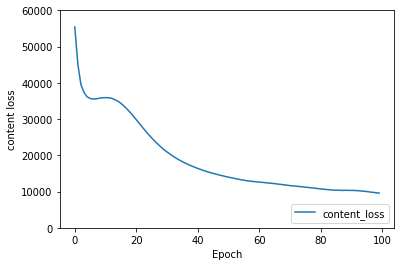

In [ ]:
import matplotlib.pyplot as plt

plt.plot(content_loss_arr, label='content_loss')
#plt.plot(style_loss_arr, label = 'style_loss')
plt.xlabel('Epoch')
plt.ylabel('content loss')
plt.ylim([0, 60000])
plt.legend(loc='lower right')

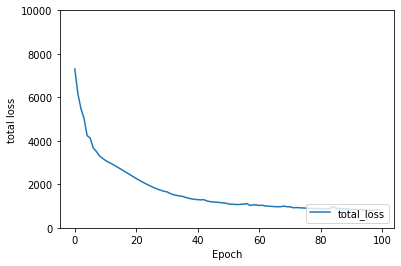

In [ ]:


plt.plot(total_loss_arr, label='total_loss')
#plt.plot(style_loss_arr, label = 'style_loss')
plt.xlabel('Epoch')
plt.ylabel('total loss')
plt.ylim([0, 10000])
plt.legend(loc='lower right')

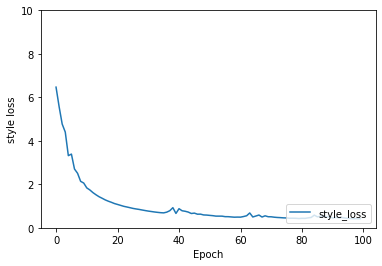

In [ ]:
plt.plot(style_loss_arr, label = 'style_loss')
plt.xlabel('Epoch')
plt.ylabel('style loss')
plt.ylim([0, 10])
plt.legend(loc='lower right')

(224, 224)


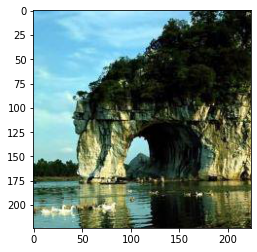

In [ ]:
from matplotlib.pyplot import imshow



img = Image.open(content_img_path)
print(img.size)

img_arr = np.asarray(img)
%matplotlib inline
imshow(img_arr)




(224, 224)


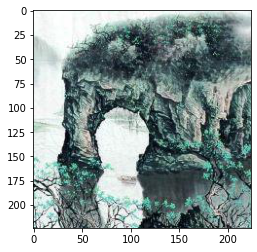

In [ ]:
img = Image.open(style_img_path)
print(img.size)

img_arr = np.asarray(img)
%matplotlib inline
imshow(img_arr)

(224, 224)


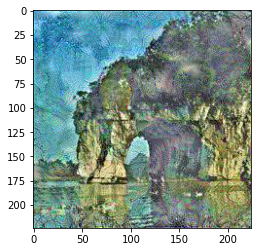

In [ ]:
transfer_img = '/content/drive/MyDrive/vgg/source_images/run_style_transfer/c3_3_s1_2/result-00050.jpg'


img = Image.open(transfer_img)
print(img.size)

img_arr = np.asarray(img)
%matplotlib inline
imshow(img_arr)